In [3]:
SAVE = False

Combine relevant evaluation files into a single file

In [4]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
# models = ['KalmanFilter', 'clipped-shallow-PLRNN']
combined_eval_file = []

for mrt in MRT:

    results_dirs = [[
        f'v3_MRT{mrt}_VAR_10splits/00_summary_7stepsahead',
        f'v3_MRT{mrt}_VAR_10splits_input_sleepjoy/00_summary_7stepsahead',
        f'v3_MRT{mrt}_VAR_10splits_input_social/00_summary_7stepsahead',
        f'v3_MRT{mrt}_VAR_10splits_input_all/00_summary_7stepsahead'
        ],
        [
        f'v3_MRT{mrt}_Kalman_10splits/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Kalman_10splits_input_sleepjoy/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Kalman_10splits_input_social/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Kalman_10splits_input_all/00_summary_7stepsahead_interv'
        ],
        [
        f'v3_MRT{mrt}_10splits/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_10splits_input_sleepjoy/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_10splits_input_social/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_10splits_input_all/00_summary_7stepsahead_interv'
        ]]

    mrt_combined_eval_file = []
    for k, rd_set in enumerate(results_dirs):
        eval_files = []
        for rd in rd_set:
            eval_files.append(data_utils.join_ordinal_bptt_path('results', rd, 'evaluation.csv'))
            assert os.path.exists(eval_files[-1]), f'{eval_files[-1]} does not exist'
        eval_reallabor_utils.clear_line_and_print(f'Combining evaluation files')
        mrt_combined_eval_file.append(eval_reallabor_utils.combine_evaluation_files(eval_files, save_path=None, specifier_name='inputs',
                                                                            specifier_values=['interventions', 'interv+activity', 'interv+social', 'all']))
    mrt_combined_eval_file = pd.concat(mrt_combined_eval_file, axis=0)
    mrt_combined_eval_file['MRT'] = mrt
    mrt_combined_eval_file['prediction'] = mrt_combined_eval_file['prediction'].clip(0, 8)

    combined_eval_file.append(mrt_combined_eval_file)

eval_reallabor_utils.clear_line_and_print(f'Creating grand combined evaluation file')
combined_eval_file = pd.concat(combined_eval_file, axis=0, ignore_index=False)
if not os.path.exists(data_utils.join_ordinal_bptt_path('results/_paper/combined_10splits_inputs_ensemble.csv')):
    os.makedirs(data_utils.join_ordinal_bptt_path('results/_paper'), exist_ok=True)
    combined_eval_file.to_csv(data_utils.join_ordinal_bptt_path('results/_paper/combined_10splits_inputs_ensemble.csv'))

Creating grand combined evaluation file                                                                                                                                                                 

Calculate all the metrics and their confidence intervals, separately for models and MRT

In [5]:
from eval_reallabor import reallabor_metrics
m_manager = reallabor_metrics.MetricsManager(combined_eval_file, ['latent_model', 'inputs'], include_r2=False, only_nonzero_differences=False)

In [9]:
test = m_manager.ttest

metrics, errorbars, test_results = {}, {}, {}
metrics['mae'] = m_manager.mae(func='mean')
errorbars['mae'] = m_manager.mae(func='sem')
test_results['mae'] = test('abs_residuals', separately_for_each='latent_model').xs('interventions', level='inputs')
metrics['diff mae'] = m_manager.diff_mae(func='mean')
errorbars['diff mae'] = m_manager.diff_mae(func='sem')
test_results['diff mae'] = test('diff_abs_residuals', separately_for_each='latent_model').xs('interventions', level='inputs')
metrics['interv mae'] = m_manager.interv_mae(func='mean')
errorbars['interv mae'] = m_manager.interv_mae(func='sem')
test_results['interv mae'] = test('interv_abs_residuals', separately_for_each='latent_model').xs('interventions', level='inputs')
metrics[r'interv. effect mae'] = m_manager.interv_diff_mae(func='mean')
errorbars[r'interv. effect mae'] = m_manager.interv_diff_mae(func='sem')
test_results[r'interv. effect mae'] = test('interv_diff_abs_residuals', separately_for_each='latent_model').xs('interventions', level='inputs')

print('Test results for mae:')
print(test_results['mae'])

Test results for mae:
                       df                                              \
inputs                all interv+activity interv+social interventions   
latent_model                                                            
KalmanFilter           33              33            33            33   
VAR1                   36              36            36            36   
clipped-shallow-PLRNN  36              36            36            36   

                      statistic                                              \
inputs                      all interv+activity interv+social interventions   
latent_model                                                                  
KalmanFilter          -1.547121       -1.918778     -1.858831           NaN   
VAR1                  -5.722559       -4.479522     -4.614051           NaN   
clipped-shallow-PLRNN  2.827961        4.017567      0.796789           NaN   

                         pvalue                                 

Plot MAE

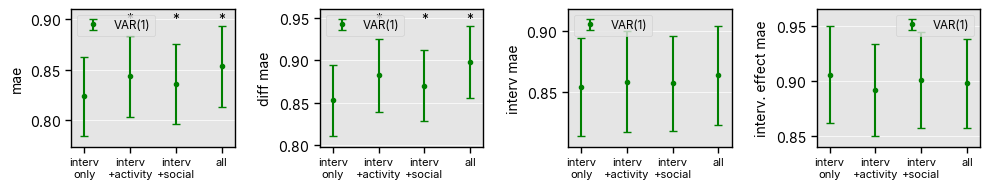

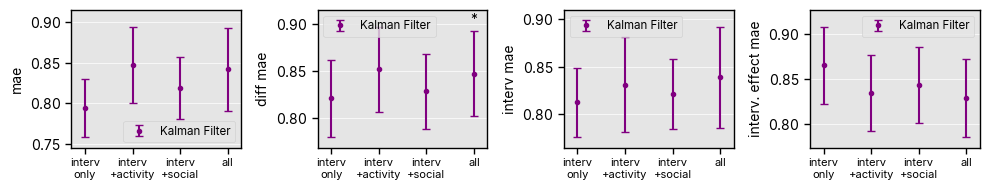

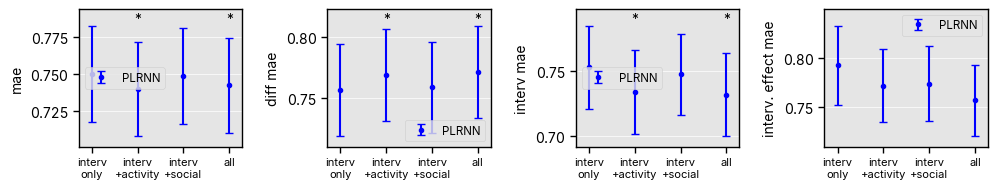

In [15]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from plotting_styles import PaperStyle, colors
from plotting_utils import adjust_lim

model_labels = {
                    'VAR1': 'VAR(1)',
                    'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    }
order = ['interventions', 'interv+activity', 'interv+social', 'all']

with PaperStyle():
    # offset = [-0.15, 0.15]
    for j, model in enumerate(model_labels.keys()):
        fig, axes = plt.subplots(1, len(metrics), figsize=(10, 2), sharex=True)
        for i, m in enumerate(metrics):
            
                # for k, mrt in enumerate(MRT):
                this_line = metrics[m].loc[(model)].loc[order]
                this_errorbars = errorbars[m].loc[(model)].loc[order].T
                axes[i].errorbar(np.arange(len(this_line)), this_line, yerr=this_errorbars, marker='.', linestyle='', capsize=3, color=colors.model_colors[model], label=model_labels[model])
                ylim = axes[i].get_ylim()
                for o, input_version in enumerate(order[1:]):
                    if test_results[m].loc[model, ('pvalue', input_version)] < 0.05:
                        axes[i].text(o+1, ylim[1], '*', ha='center', va='bottom')
                axes[i].set_xticks(ticks=np.arange(len(this_line)), labels=['interv\nonly', 'interv\n+activity', 'interv\n+social', 'all'], rotation=0, ha='center', fontsize=8)

                adjust_lim(axes[i], 0.01, 0.01, 'x')
                adjust_lim(axes[i], 0.15, 0.1, 'y')

                axes[i].set(ylabel=m)
                axes[i].legend()

        plt.tight_layout()
        if SAVE:
            plt.savefig(f'../results/_paper/determinants_of_forecasting_quality/inputs_10splits_ensemble_{model}.svg', dpi=300)
    plt.show()

Get C matrices

In [16]:
import torch as tc
import utils

all_C = []
all_A = []

for mrt in MRT:

    results_dirs = [[
        f'v2_MRT{mrt}_Kalman_10splits/00_summary_7stepsahead_ensemble',
        f'v2_MRT{mrt}_Kalman_10splits_input_sleepjoy/00_summary_7stepsahead_ensemble',
        f'v2_MRT{mrt}_Kalman_10splits_input_social/00_summary_7stepsahead_ensemble',
        f'v2_MRT{mrt}_Kalman_10splits_input_all/00_summary_7stepsahead_ensemble'
        ],
        [
        f'v2_MRT{mrt}_10splits/00_summary_7stepsahead_ensemble',
        f'v2_MRT{mrt}_10splits_input_sleepjoy/00_summary_7stepsahead_ensemble',
        f'v2_MRT{mrt}_10splits_input_social/00_summary_7stepsahead_ensemble',
        f'v2_MRT{mrt}_10splits_input_all/00_summary_7stepsahead_ensemble'
        ]]
    
    mrt_C = []
    mrt_A = []
    for rd_set in results_dirs:
        model_C = []
        model_A = []
        for rd in rd_set:
            version_C = []
            version_A = []
            model_dirs = eval_reallabor_utils.get_model_folders(data_utils.join_ordinal_bptt_path('results', rd.split('/')[0]))
            for md in model_dirs:
                args = utils.load_args(md)
                model_class = eval_reallabor_utils.determine_model_class(args)
                if 'PLRNN' in str(model_class):
                    state_dict = tc.load(os.path.join(md, f'model_{utils.available_epochs(md)[-1]}.pt'))
                    C = state_dict['parameters_.C'].detach().numpy()
                    A = np.diag(state_dict['parameters_.A'].detach().numpy())
                else:
                    state_dict = tc.load(os.path.join(md, 'model.pt'))
                    C = state_dict['B'].detach().numpy()
                    A = state_dict['A'].detach().numpy()
                C = np.abs(C).mean(axis=0)
                A = np.abs(np.linalg.norm(A, 2))
                version_C.append(C)
                version_A.append(A)
            version_C = np.stack(version_C, axis=1)
            version_C = pd.DataFrame(version_C.T, columns=args['input_features'])
            version_C['norm A'] = version_A
            model_C.append(version_C)
        model_C = pd.concat(model_C, axis=0, keys=['interventions', 'interv+activity', 'interv+social', 'all'], names=['inputs'])
        mrt_C.append(model_C)
    mrt_C = pd.concat(mrt_C, axis=0, keys=model_labels.values(), names=['latent_model'])
    all_C.append(mrt_C)
all_C = pd.concat(all_C, axis=0, keys=MRT, names=['MRT'])    


/tmp/ipykernel_2821347/3723764922.py:52: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  mrt_C = pd.concat(mrt_C, axis=0, keys=model_labels.values(), names=['latent_model'])
/tmp/ipykernel_2821347/3723764922.py:52: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  mrt_C = pd.concat(mrt_C, axis=0, keys=model_labels.values(), names=['latent_model'])


In [7]:
all_C.loc[2].groupby(['latent_model', 'inputs']).mean()

interactive1  interactive2  interactive3  \
latent_model  inputs                                                      
Kalman Filter all                  0.074970      0.076389      0.083611   
              interv+activity      0.074029      0.076975      0.082675   
              interv+social        0.071330      0.073208      0.074629   
              interventions        0.069771      0.073277      0.073067   
PLRNN         all                  0.163742      0.155250      0.150485   
              interv+activity      0.169822      0.162096      0.157371   
              interv+social        0.178631      0.167478      0.163586   
              interventions        0.188893      0.181412      0.175513   

                               interactive4  interactive5  interactive6  \
latent_model  inputs                                                      
Kalman Filter all                  0.076392      0.072186      0.075252   
              interv+activity      0.077942      0.071949      0.084594   
              interv+social        0.071204      0.068449      0.067065   
              interventions        0.068143      0.065731      0.067213   
PLRNN         all                  0.150130      0.156143      0.149072   
              interv+activity      0.156242      0.164878      0.154935   
              interv+social        0.161625      0.167329      0.161227   
              interventions        0.173516      0.177159      0.172540   

                               interactive7  interactive8    norm A  \
latent_model  inputs                                                  
Kalman Filter all                  0.066520      0.071131  3.650023   
              interv+activity      0.070672      0.074316  3.989456   
              interv+social        0.064459      0.068495  3.581014   
              interventions        0.064113      0.066772  3.644436   
PLRNN         all                  0.152661      0.154608  0.446408   
              interv+activity      0.154326      0.156777  0.448442   
              interv+social        0.163074      0.168737  0.450248   
              interventions        0.175889      0.180032  0.453016   

                               EMA_sleep  EMA_joyful_day  \
latent_model  inputs                                       
Kalman Filter all               0.076975        0.088625   
              interv+activity   0.080353        0.094274   
              interv+social          NaN             NaN   
              interventions          NaN             NaN   
PLRNN         all               0.154297        0.165139   
              interv+activity   0.159099        0.170430   
              interv+social          NaN             NaN   
              interventions          NaN             NaN   

                               EMA_feelactive_sincebeep  EMA_activity_pleas  \
latent_model  inputs                                                          
Kalman Filter all                              0.040849            0.049375   
              interv+activity                  0.043150            0.042267   
              interv+social                         NaN                 NaN   
              interventions                         NaN                 NaN   
PLRNN         all                              0.125989            0.141093   
              interv+activity                  0.133241            0.149884   
              interv+social                         NaN                 NaN   
              interventions                         NaN                 NaN   

                               EMA_social_satisfied  EMA_social_alone_yes  
latent_model  inputs                                                       
Kalman Filter all                          0.105024              0.099050  
              interv+activity                   NaN                   NaN  
              interv+social                0.081451              0.086809  
              interventions                   